In [151]:
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

In [152]:
# Reading the data

df = pd.read_parquet("../data/green/green_tripdata_2021-01.parquet")
print(f"columns: {df.dtypes}")

columns: VendorID                          Int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                        Int64
PULocationID                      Int64
DOLocationID                      Int64
passenger_count                   Int64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                      Int64
trip_type                         Int64
congestion_surcharge            float64
dtype: object


In [153]:
df.head(10)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1,43,151,1,1.01,5.5,0.5,0.5,0.00,0.0,NaN,0.3,6.80,2,1,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1,166,239,1,2.53,10.0,0.5,0.5,2.81,0.0,NaN,0.3,16.86,1,1,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1,41,42,1,1.12,6.0,0.5,0.5,1.00,0.0,NaN,0.3,8.30,1,1,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1,168,75,1,1.99,8.0,0.5,0.5,0.00,0.0,NaN,0.3,9.30,2,1,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2,265,265,3,0.00,-52.0,0.0,-0.5,0.00,0.0,NaN,-0.3,-52.80,3,1,0.00
5,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2,265,265,3,0.00,52.0,0.0,0.5,0.00,0.0,NaN,0.3,52.80,2,1,0.00
6,2,2021-01-01 00:19:14,2021-01-01 00:19:21,N,5,265,265,1,0.00,180.0,0.0,0.0,36.06,0.0,NaN,0.3,216.36,1,2,0.00
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1,75,75,6,0.45,3.5,0.5,0.5,0.96,0.0,NaN,0.3,5.76,1,1,0.00
8,2,2021-01-01 00:57:46,2021-01-01 00:57:57,N,1,225,225,1,0.00,2.5,0.5,0.5,0.00,0.0,NaN,0.3,3.80,2,1,0.00
9,2,2021-01-01 00:58:32,2021-01-01 01:32:34,N,1,225,265,1,12.19,38.0,0.5,0.5,2.75,0.0,NaN,0.3,42.05,1,1,0.00


In [154]:
# Computing duration
df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

# Dropping outliers
len(df[(df.duration >= 1) & (df.duration <= 60)]) / len(df) * 100


# Filter the data to include only trips between 1 and 60 mins
df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

In [155]:
# One-hot encoding
categorical = ["PULocationID", "DOLocationID"]

df[categorical] = df[categorical].astype(str)
train_dicts = df[categorical].to_dict(orient="records")

In [156]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

print(f"Feature matrix size: {X_train.shape}")

Feature matrix size: (73908, 506)


In [157]:
# Training a model
target = "duration"
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f"Train RMSE: {mean_squared_error(y_train, y_pred, squared=False)}")

Train RMSE: 9.775596032099234


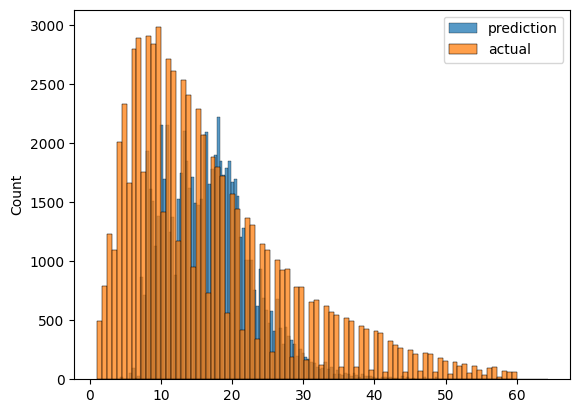

In [158]:
sns.histplot(y_pred, label="prediction")
sns.histplot(y_train, label="actual")

plt.legend();

In [159]:
# Evaluating the model
categorical = ["PULocationID", "DOLocationID"]


def read_dataframe(filename):
    if filename.endswith(".csv"):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith(".parquet"):
        df = pd.read_parquet(filename)

    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)

    return df

In [160]:
df_train = read_dataframe("../data/green/green_tripdata_2021-01.parquet")
df_val = read_dataframe("../data/green/green_tripdata_2021-02.parquet")

len(df_train), len(df_val)

(73908, 61921)

In [161]:
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]

In [162]:
categorical = ["PU_DO"]  #'PULocationID', 'DOLocationID']
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [163]:
target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

In [164]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715206735978

In [165]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728